# Imports

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import math
from tqdm.notebook import tqdm
import iteration_utilities
import itertools
import statsmodels
import scipy.optimize
import scipy.spatial.distance as sd
from lmfit import *
from matplotlib.lines import Line2D

mpl.rcParams["font.sans-serif"] = "Arial"
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["pdf.fonttype"] = 42
sns.set_style(
    "ticks",
    {
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "font_color": "k",
        "axes.edgecolor": "k",
        "xtick.color": "k",
        "ytick.color": "k",
    },
)
sns.set_context("talk", font_scale=1.0)

# Loading Data

In [2]:
df1 = pd.read_csv(
    "../02_repressor_validations/2021.11.17_repression_round1/data/all_cells_live_mch_gated.csv"
)
df2 = pd.read_csv(
    "../02_repressor_validations/2022.04.18_repadd_stapl/data/all_cells_mch_live.csv"
)
df2 = df2[df2['asv']==0]
dfx = pd.concat([df1, df2])
dfx.head()

,FSC 488/10-A,SSC 488/10-A,day,description,dox,mCherry-A,mCitrine-A,plasmid,replicate,treatment,P1,mCherry,asv
0,8.317540e+08,219492864.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,14387968.0,85923072.0,59,1.0,none,True,True,NaN
1,4.958666e+08,180896512.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,104767232.0,66599936.0,59,1.0,none,True,True,NaN
2,4.226458e+08,101837056.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,26209536.0,61377280.0,59,1.0,none,False,True,NaN
3,1.038254e+09,372244224.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,365425920.0,376630272.0,59,1.0,none,True,True,NaN
4,8.091105e+08,349765120.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,180713472.0,1863680.0,59,1.0,none,True,True,NaN


In [3]:
df = dfx[dfx["P1"]]
df = df[df["mCherry"]]
df = df[~df["treatment"].isin(["DMSO", "9-c-RA"])]
df = df.drop(
    ["FSC 488/10-A", "SSC 488/10-A", "mCherry-A", "P1", "mCherry", "treatment", "asv"],
    axis=1,
)
df.head()

,day,description,dox,mCitrine-A,plasmid,replicate
0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,85923072.0,59,1.0
1,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,66599936.0,59,1.0
3,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,376630272.0,59,1.0
4,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,1863680.0,59,1.0
5,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,183085824.0,59,1.0


# Computing Norm D5 Off

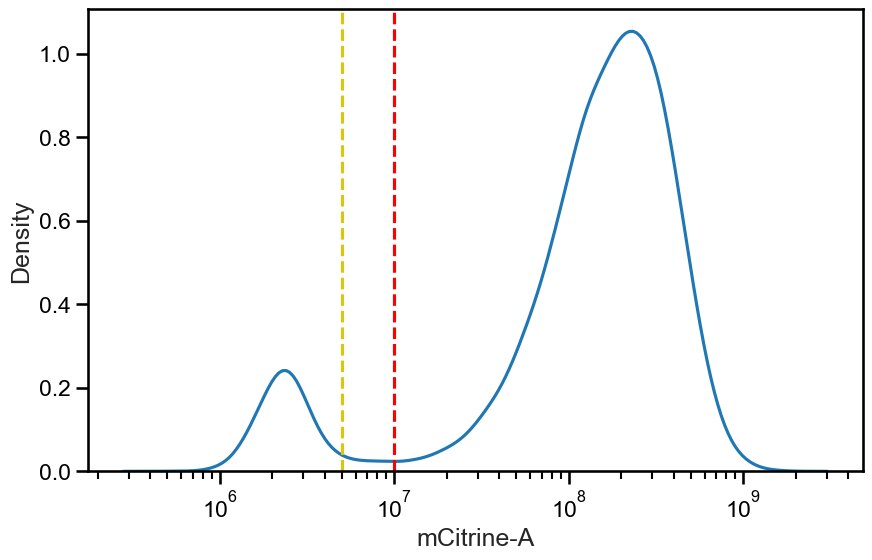

In [4]:
g = sns.kdeplot(
    data=df[(df["day"] == 0) & (df["plasmid"] == 126)], x="mCitrine-A", log_scale=True
)
g.axvline(1e7, color='red', linestyle='--')
g.axvline(5e6, color='#dbc60d', linestyle='--')
citrine_threshold = 1e7 #4e7

In [5]:
gdf = df[df["day"] == 5]
gdf['citrine OFF'] = gdf['mCitrine-A'] < citrine_threshold
mdf = (
    gdf.groupby(["day", "plasmid", "description", "replicate", "dox"])
    .mean()
    .reset_index()
)
mdf = mdf.pivot(
    index=["plasmid", "description", "replicate"], columns="dox", values="citrine OFF"
).reset_index()
mdf['norm_off'] = (mdf[1000.0]-mdf[0.0])/(1.0-mdf[0.0])
mdf = mdf.groupby(['plasmid', 'description']).mean().reset_index()
mdf = mdf[['plasmid', 'description', 'norm_off']]
mdf

/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_4786/3693916740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['citrine OFF'] = gdf['mCitrine-A'] < citrine_threshold


dox,plasmid,description,norm_off
0,56,STaPL-only,-0.009536
1,59,ZIK1 KRAB + Rand Ctrl 89,0.993977
2,61,KMT2C Dual + FOXO3 TAD,0.834383
3,63,KMT2D Dual + ZNF10 KRAB,0.994361
4,65,KMT2D Dual + Rand Ctrl 89,0.005052
5,72,Rand Ctrl + Rand Ctrl 89,0.004668
6,73,FOXO3-STaPL-ZNF10,0.385425
7,74,DMD - DMD,0.011238
8,75,DMD - RANDCTRL,0.008820
9,76,ZNF10 - ANM2,0.993904


# Comparing to Screen Score

In [6]:
screen_data = pd.read_csv('../01_repressor_additivity/pairs_baselinesums.csv')
screen_data.head()

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,d2_description,d2_baseline_type,d2_prior_type,composition,character,ptype,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,Repressor,Non-hit,Repressor,D-N,Other,Effector Pair,True,True,1.126839,2.456298
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,Repressor,Dual,Repressor,D-D,Other,Effector Pair,True,True,5.959180,0.706417
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,Repressor,Repressor,Repressor,R-R,Repressor,Effector Pair,False,True,-3.901673,-1.582110
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,Activator,Dual,Activator,D-D,Other,Effector Pair,True,True,5.391484,1.549693
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,Repressor,Non-hit,Repressor,R-N,Other,Effector Pair,False,True,-3.468438,-1.231666


In [7]:
oligos = pd.read_csv(
    "../../fig_1/01_raw_counts/csvs/base_oligo_library.csv"
)


def domain_from_gene(g):
    if g == "Rand372":
        return "Random_control;;;372;"
    elif g == "Ctrl" or g == "CTRL" or g == "DMD297":
        return "DMD_control_tiles;ENSG00000198947;;297;"
    else:
        of = oligos[oligos["Gene"] == g]
        assert len(list(of["label"])) == 1
        return list(of["label"])[0]


def get_domains(plasmid, description):
    if plasmid == 75:
        return ["DMD_control_tiles;ENSG00000198947;;297;", "Random_control;;;21;"]
    elif plasmid == 74:
        return [
            "DMD_control_tiles;ENSG00000198947;;131;",
            "DMD_control_tiles;ENSG00000198947;;297;",
        ]
    elif plasmid == 78:
        return ["Random_control;;;205;", "Random_control;;;410;"]
    # find the domain for each of the elements
    if " - " not in description and "-" not in description:
        print(plasmid, description)
    if " - " in description:
        d1, d2 = description.split(" - ")
    elif "-" in description:
        d1, d2 = description.split("-")
    return [domain_from_gene(d1), domain_from_gene(d2)]

In [8]:
pdf = mdf[(mdf["plasmid"] > 73) & (~mdf["plasmid"].isin([126, 217, 222, 144]))]
pdf

dox,plasmid,description,norm_off
7,74,DMD - DMD,0.011238
8,75,DMD - RANDCTRL,0.008820
9,76,ZNF10 - ANM2,0.993904
10,76,ZNF10-ANM2,0.990531
11,77,ZNF10 - CBX1,0.994560
12,77,ZNF10-CBX1,0.990713
13,78,RANDCTRL - RANDCTRL,0.019724
14,79,ANM2 - KIBRA,0.063765
15,80,BIN1 - FOXO3,0.886871
16,81,CACO1 - ANM2,0.053271


In [9]:
pairs = [
    get_domains(p, d)
    for p, d in zip(list(pdf["plasmid"]), list(pdf["description"]))
]
pdf["domain1"] = [p[0] for p in pairs]
pdf["domain2"] = [p[1] for p in pairs]
pdf["pair"] = [p[0] + " --- " + p[1] for p in pairs]
pdf

/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_4786/570656686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["domain1"] = [p[0] for p in pairs]
/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_4786/570656686.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["domain2"] = [p[1] for p in pairs]
/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_4786/570656686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

dox,plasmid,description,norm_off,domain1,domain2,pair
7,74,DMD - DMD,0.011238,DMD_control_tiles;ENSG00000198947;;131;,DMD_control_tiles;ENSG00000198947;;297;,DMD_control_tiles;ENSG00000198947;;131; --- DM...
8,75,DMD - RANDCTRL,0.008820,DMD_control_tiles;ENSG00000198947;;297;,Random_control;;;21;,DMD_control_tiles;ENSG00000198947;;297; --- Ra...
9,76,ZNF10 - ANM2,0.993904,Human_KRAB_variant;P21506;146,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,Human_KRAB_variant;P21506;146 --- Short_nuclea...
10,76,ZNF10-ANM2,0.990531,Human_KRAB_variant;P21506;146,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,Human_KRAB_variant;P21506;146 --- Short_nuclea...
11,77,ZNF10 - CBX1,0.994560,Human_KRAB_variant;P21506;146,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,Human_KRAB_variant;P21506;146 --- Short_nuclea...
12,77,ZNF10-CBX1,0.990713,Human_KRAB_variant;P21506;146,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,Human_KRAB_variant;P21506;146 --- Short_nuclea...
13,78,RANDCTRL - RANDCTRL,0.019724,Random_control;;;205;,Random_control;;;410;,Random_control;;;205; --- Random_control;;;410;
14,79,ANM2 - KIBRA,0.063765,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,Short_nuclear_domain;KIBRA_HUMAN;WW;1;29,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45 --...
15,80,BIN1 - FOXO3,0.886871,Short_nuclear_domain;BIN1_HUMAN;SH3_9;513;63,Short_nuclear_domain;FOXO3_HUMAN;FOXO-TAD;584;41,Short_nuclear_domain;BIN1_HUMAN;SH3_9;513;63 -...
16,81,CACO1 - ANM2,0.053271,Short_nuclear_domain;CACO1_HUMAN;Zn-C2H2_12;61...,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,Short_nuclear_domain;CACO1_HUMAN;Zn-C2H2_12;61...


In [10]:
jdf = pdf.set_index('pair').join(
    screen_data.set_index('pair'),
    how = 'left',
    rsuffix = '_screen'
).reset_index()
jdf

,pair,plasmid,description,norm_off,domain1,domain2,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,...,d2_description,d2_baseline_type,d2_prior_type,composition,character,ptype,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5
0,DMD_control_tiles;ENSG00000198947;;131; --- DM...,74,DMD - DMD,0.011238,DMD_control_tiles;ENSG00000198947;;131;,DMD_control_tiles;ENSG00000198947;;297;,2 control Pair,-1.357524,2.056711,-1.241566,...,Control,Control,Control,C-C,Control,Control Pair,False,False,NaN,NaN
1,DMD_control_tiles;ENSG00000198947;;297; --- Ra...,75,DMD - RANDCTRL,0.008820,DMD_control_tiles;ENSG00000198947;;297;,Random_control;;;21;,2 control Pair,-1.657747,1.840322,-1.086945,...,Control,Control,Control,C-C,Control,Control Pair,False,False,NaN,NaN
2,Human_KRAB_variant;P21506;146 --- Random_contr...,181,ZNF10-Rand372,0.989438,Human_KRAB_variant;P21506;146,Random_control;;;372;,1 control Pair,-2.876175,-2.758037,-3.220051,...,Control,Control,Control,R-C,Repressor,Effector Pair,False,True,-3.935008,-2.693280
3,Human_KRAB_variant;P21506;146 --- Short_nuclea...,76,ZNF10 - ANM2,0.993904,Human_KRAB_variant;P21506;146,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,0 control Pair,-3.060923,-4.044540,-2.337508,...,Activator,Activator,Activator,R-A,Both,Effector Pair,False,True,-2.290708,-1.332709
4,Human_KRAB_variant;P21506;146 --- Short_nuclea...,76,ZNF10-ANM2,0.990531,Human_KRAB_variant;P21506;146,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,0 control Pair,-3.060923,-4.044540,-2.337508,...,Activator,Activator,Activator,R-A,Both,Effector Pair,False,True,-2.290708,-1.332709
5,Human_KRAB_variant;P21506;146 --- Short_nuclea...,77,ZNF10 - CBX1,0.994560,Human_KRAB_variant;P21506;146,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,0 control Pair,-2.264251,0.231829,-3.559901,...,Repressor,Repressor,Repressor,R-R,Repressor,Effector Pair,False,True,-5.247002,-5.763322
6,Human_KRAB_variant;P21506;146 --- Short_nuclea...,77,ZNF10-CBX1,0.990713,Human_KRAB_variant;P21506;146,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,0 control Pair,-2.264251,0.231829,-3.559901,...,Repressor,Repressor,Repressor,R-R,Repressor,Effector Pair,False,True,-5.247002,-5.763322
7,Random_control;;;205; --- Random_control;;;410;,78,RANDCTRL - RANDCTRL,0.019724,Random_control;;;205;,Random_control;;;410;,2 control Pair,-1.120361,1.508892,-1.687775,...,Control,Control,Control,C-C,Control,Control Pair,False,False,-2.929481,0.671557
8,Random_control;;;372; --- Short_nuclear_domain...,183,Rand372-ANM2,-0.020535,Random_control;;;372;,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,1 control Pair,0.117576,2.399861,-0.500127,...,Activator,Activator,Activator,C-A,Activator,Effector Pair,False,False,-1.323747,2.214909
9,Random_control;;;372; --- Short_nuclear_domain...,182,Rand372-CBX1,0.990262,Random_control;;;372;,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,1 control Pair,-2.629184,-1.809098,-3.019474,...,Repressor,Repressor,Repressor,C-R,Repressor,Effector Pair,False,True,-4.280041,-2.215704


# Fitting Sigmoids to Correlation

(-0.05, 1.05)

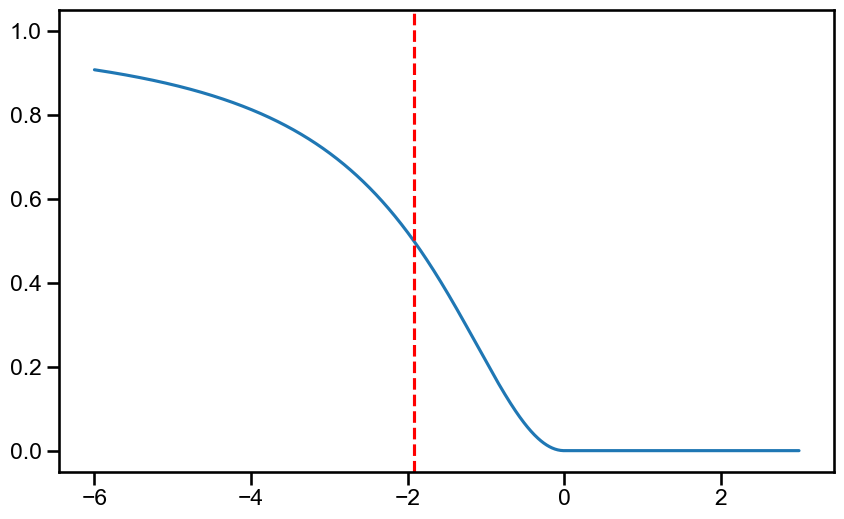

In [11]:
from scipy.optimize import curve_fit


def f_sigmoid(s, thresh, kd, n):
    if isinstance(s, int) or isinstance(s, float):
        s = np.array([s])
    elif isinstance(s, list):
        s = np.array(s)
    # else we assume np array
    res = [0 for _ in s]
    for i, v in enumerate(s):
        if v <= thresh:
            res[i] = 1 - 1 / (1 + ((v + thresh) / (kd)) ** n)
    return res


def n_sigmoid(s, t, kd, n):
    res = [0 for _ in s]
    for i, v in enumerate(s):
        if v >= t:
            res[i] = 0
        else:
            res[i] = 1 - 1 / (1 + ((v - t) / (kd - t)) ** n)
    return res


params = [0, -1.92296824, 2.0]

fig, ax = plt.subplots()
x = np.linspace(-6, 3, 1000)
y = n_sigmoid(x, *params)
ax.plot(x, y)
ax.axvline(params[1], color="r", ls="--")
ax.set_ylim(-0.05, 1.05)

In [12]:
sigdf = jdf.dropna(subset=["avg_enrichment_d5", "norm_off"])
popt, _ = curve_fit(
    f=n_sigmoid,
    xdata=np.array(list(sigdf["avg_enrichment_d5"])),
    ydata=np.array(list(sigdf["norm_off"])),
    p0=[3, -2.5, 5],
    bounds=[[2.9, -6, 1], [3.001, 3, 10]],
    method="dogbox",
)

co_popt = popt

print("Thresh={:.02f}, kd={:.02f}, n={:.02f}".format(*popt))

Thresh=3.00, kd=0.22, n=3.78


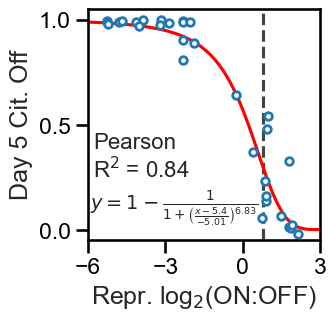

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.axvline(0.771, ymin=0, ymax=1.0, color="#444444", linestyle="--", zorder=-10)

sns.scatterplot(
    data=jdf,
    x="avg_enrichment_d5",
    y="norm_off",
    marker="o",
    edgecolor="tab:blue",
    linewidth=2,
    color="white",
    s=30,
    ax=ax,
)

ax.set_xlim(-6, 3)
ax.set_xticks([-6, -3, 0, 3])
ax.set_ylim(-0.05, 1.05)
ax.set_yticks([0, 0.5, 1.0])

ax.plot(
    np.linspace(-6, 3, 1000),
    n_sigmoid(np.linspace(-6, 3, 1000), *popt),
    color="red",
    zorder=-10,
)


xdf = jdf.dropna(subset=["avg_enrichment_d5", "norm_off"])
r, p = st.pearsonr(xdf["avg_enrichment_d5"], xdf["norm_off"])
ax.text(-5.8, 0.25, "Pearson\nR$^2$ = {:.2f}".format(r**2), fontsize=16)
ax.text(
    x=-5.9,
    y=0.1,
    s="$y=1-\\frac{1}{1 + \\left( \\frac{x-5.4}{-5.01} \\right)^{6.83}}}$",
    # t$=0$\nh$=2.36$\nn$=3.00$",
    fontsize=14,
)

ax.set_xlabel("Repr. log$_2$(ON:OFF)")
ax.set_ylabel("Day 5 Cit. Off")

fig.savefig("./repr_sigmoid.pdf", bbox_inches="tight")

# Sigmoid Comparison Plot

In [14]:
def rep_fun(e):
    return n_sigmoid(e, *co_popt)

In [15]:
rsdf = screen_data[screen_data['composition'].isin(['C-C', 'R-R'])]
rsdf['rep_combo_est_d5_off'] = rep_fun(rsdf['avg_enrichment_d5'])
rsdf['rep_bsum_est_d5_off'] = rep_fun(rsdf['d1_med_d5'] + rsdf['d2_med_d5'])

group_labels = [
    "Neg. Ctrl Domain Pairs",
    "Low Expected Repression",
    "Med Expected Repression",
    "High Expected Repression",
]


def get_act_group(s, c):
    if c == "C-C":
        return group_labels[0]
    elif s >= -2.5:
        return group_labels[1]
    elif s >= -5:
        return group_labels[2]
    else:
        return group_labels[3]


rsdf["rep_group"] = [
    get_act_group(s, c)
    for s, c in zip(rsdf["baseline_sum_d5"], rsdf["composition"])
]

rsdf.head()

/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_4786/4043797198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rsdf['rep_combo_est_d5_off'] = rep_fun(rsdf['avg_enrichment_d5'])
/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_4786/4043797198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rsdf['rep_bsum_est_d5_off'] = rep_fun(rsdf['d1_med_d5'] + rsdf['d2_med_d5'])
/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_4786/4043797198.py:24: SettingWithCopyWarning: 
A value 

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,composition,character,ptype,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5,rep_combo_est_d5_off,rep_bsum_est_d5_off,rep_group
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,R-R,Repressor,Effector Pair,False,True,-3.901673,-1.582110,0.899243,0.868019,Low Expected Repression
12,Silencer_tiles;ENSG00000076108;118 --- Silence...,0 control Pair,-2.990265,-2.355584,-2.394019,-1.797338,0.111779,0.163452,0.159842,0.223425,...,R-R,Repressor,Effector Pair,False,True,-3.559434,-3.519550,0.906424,0.961440,Med Expected Repression
21,Silencer_tiles;ENSG00000102974;12 --- Short_nu...,0 control Pair,-1.946998,-1.856085,-1.983061,-2.514328,0.205943,0.216439,0.201885,0.148958,...,R-R,Repressor,Effector Pair,False,True,-2.790764,-1.054846,0.913000,0.805590,Low Expected Repression
42,Short_nuclear_domain;CACO1_HUMAN;Zn-C2H2_12;61...,0 control Pair,-0.580952,-0.702747,0.423365,-0.412057,0.400667,0.380575,0.572841,0.429078,...,R-R,Repressor,Effector Pair,False,True,-1.340963,2.680393,0.716473,0.000283,Low Expected Repression
74,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-3.737496,-3.608713,-3.231400,-4.343375,0.069744,0.075762,0.096230,0.046949,...,R-R,Repressor,Effector Pair,False,True,-4.360371,-6.094026,0.969880,0.988727,High Expected Repression


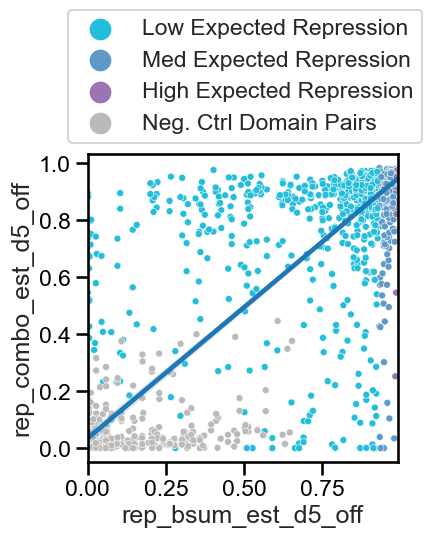

In [16]:
fig, ax = plt.subplots(figsize=(4,4))

sns.scatterplot(
    data = rsdf,
#    x = 'baseline_sum_d5',
    x = 'rep_bsum_est_d5_off',
    y = 'rep_combo_est_d5_off',
    hue = 'rep_group',
    palette = ['#23bedb', '#5f99c7', '#9a74b3', '#bababa'],
    s = 25,
    ax=ax
)
sns.regplot(
    data = rsdf,
#    x = 'baseline_sum_d5',
    x = 'rep_bsum_est_d5_off',
    y = 'rep_combo_est_d5_off',
    #hue = 'rep_group',
    #palette = ['#23bedb', '#5f99c7', '#9a74b3', '#bababa'],
    scatter=False,
    robust=True,
    ax=ax
)

xvals = np.linspace(-6, 3, 1000)
yvals = rep_fun(xvals)
# ax.plot(xvals, yvals, ls='--', color='tab:red', zorder=-10)

l = ax.legend(loc="lower left", bbox_to_anchor=(-0.1, 1))
for m in l.legendHandles:
    m._sizes = [200]

# Comparing screen scores to D5 Frac. Off

In [17]:
mdf = pd.read_csv("../04_repressor_modeling/data/telegraph_parameters.csv")
mdf

,Unnamed: 0,plasmid,bg,on,ks,tlag,bprime,lambda,s_on,gamma,u_off,s_off,good_fit
0,0,56,0.137338,0.842776,0.000000,0.000000,1.000000e+00,1085.283891,0.389608,0.000000,6.384903,0.100000,True
1,0,59,0.137338,0.000000,3.611963,0.871167,1.000000e+00,1219.223973,0.305566,0.251634,6.356269,0.135930,True
2,0,61,0.137338,0.000000,0.988326,0.874945,1.000000e+00,1208.459494,0.317639,0.224511,6.389901,0.185787,True
3,0,63,0.137338,0.000000,3.373775,0.846723,1.000000e+00,1146.115615,0.397163,0.251755,6.329006,0.134828,True
4,0,65,0.137338,0.874406,0.000000,0.000000,3.649005e-18,1085.462214,0.357050,0.000000,6.350098,0.100000,True
5,0,72,0.137338,0.860922,0.000000,0.000000,1.000000e+00,1217.272297,0.315533,0.000000,6.405396,0.100000,True
6,0,73,0.137338,0.464474,2.457685,1.757687,1.000000e+00,1183.844521,0.351320,0.092662,6.359735,0.100000,False
7,0,74,0.137338,0.884812,0.000000,0.000000,1.910943e-17,1269.432090,0.306933,0.000000,6.412158,0.100000,True
8,0,75,0.137338,0.867762,0.000000,0.000000,8.280290e-18,1299.531519,0.307403,0.000000,6.390910,0.100000,True
9,0,76,0.137338,0.000000,3.320729,0.724178,1.000000e+00,1231.843045,0.422966,0.264740,6.338312,0.152478,True


In [18]:
kdf = jdf.set_index("plasmid").join(mdf.set_index("plasmid"), how="left").reset_index()
kdf = kdf[kdf["good_fit"]]
kdf = kdf.dropna(subset=["avg_enrichment_d5", "ks"])
kdf.head()

,plasmid,pair,description,norm_off,domain1,domain2,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,...,on,ks,tlag,bprime,lambda,s_on,gamma,u_off,s_off,good_fit
0,74,DMD_control_tiles;ENSG00000198947;;131; --- DM...,DMD - DMD,0.011238,DMD_control_tiles;ENSG00000198947;;131;,DMD_control_tiles;ENSG00000198947;;297;,2 control Pair,-1.357524,2.056711,-1.241566,...,0.884812,0.000000,0.000000,1.910943e-17,1269.432090,0.306933,0.00000,6.412158,0.100000,True
1,75,DMD_control_tiles;ENSG00000198947;;297; --- Ra...,DMD - RANDCTRL,0.008820,DMD_control_tiles;ENSG00000198947;;297;,Random_control;;;21;,2 control Pair,-1.657747,1.840322,-1.086945,...,0.867762,0.000000,0.000000,8.280290e-18,1299.531519,0.307403,0.00000,6.390910,0.100000,True
2,76,Human_KRAB_variant;P21506;146 --- Short_nuclea...,ZNF10 - ANM2,0.993904,Human_KRAB_variant;P21506;146,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,0 control Pair,-3.060923,-4.044540,-2.337508,...,0.000000,3.320729,0.724178,1.000000e+00,1231.843045,0.422966,0.26474,6.338312,0.152478,True
3,76,Human_KRAB_variant;P21506;146 --- Short_nuclea...,ZNF10-ANM2,0.990531,Human_KRAB_variant;P21506;146,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,0 control Pair,-3.060923,-4.044540,-2.337508,...,0.000000,3.320729,0.724178,1.000000e+00,1231.843045,0.422966,0.26474,6.338312,0.152478,True
4,77,Human_KRAB_variant;P21506;146 --- Short_nuclea...,ZNF10 - CBX1,0.994560,Human_KRAB_variant;P21506;146,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,0 control Pair,-2.264251,0.231829,-3.559901,...,0.000000,3.081645,0.714742,1.000000e+00,1224.238428,0.426342,0.27110,6.342728,0.146657,True


In [19]:
kdf["avg_enrichment_d5"].describe()

count    26.000000
mean     -1.774604
std       2.647552
min      -5.271272
25%      -3.995866
50%      -2.332029
75%       0.978141
max       2.144105
Name: avg_enrichment_d5, dtype: float64

In [20]:
def k_sigmoid(s, kd, n):
    res = [0 for _ in s]
    t = 3.5
    for i, v in enumerate(s):
        if v >= t:
            res[i] = 0
        else:
            res[i] = 4 - 4 * (1 / (1 + ((v - t) / (kd - t)) ** n))
    return res

In [21]:
popt, _ = curve_fit(
    f=k_sigmoid,
    xdata=np.array(list(kdf["avg_enrichment_d5"])),
    ydata=np.array(list(kdf["ks"])),
    p0=[-2.5, 7.5],
    bounds=[[-6, 1], [0, 10]],
    method="dogbox",
)

print("kd={:.2f}, n={:.2f}".format(*popt))

kd=-1.32, n=2.95


r=-0.86, p=0.00


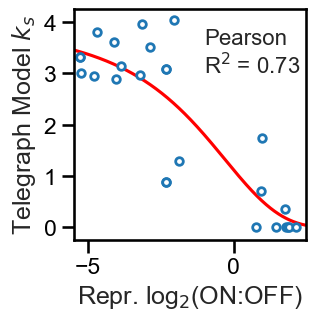

In [22]:
fig, ax = plt.subplots(figsize=(3, 3))

r, p = st.pearsonr(kdf["avg_enrichment_d5"], kdf["ks"])
print("r={:.2f}, p={:.2f}".format(r, p))


ax.plot(
    np.linspace(-6, 3, 1000),
    k_sigmoid(np.linspace(-6, 3, 1000), *popt),
    color="red",
    zorder=-10,
)

ax.text(-1, 3, "Pearson\nR$^2$ = {:.2f}".format(r**2), fontsize=16)

sns.scatterplot(
    data=kdf,
    x="avg_enrichment_d5",
    y="ks",
    marker="o",
    edgecolor="tab:blue",
    linewidth=2,
    color="white",
    s=30,
    ax=ax,
)

ax.set_ylim(-0.25, 4.25)
ax.set_xlim(-5.5, 2.5)

ax.set_xlabel("Repr. log$_2$(ON:OFF)")
ax.set_ylabel("Telegraph Model $k_s$")

fig.savefig("./repr_ks_sigmoid.pdf", bbox_inches="tight")

In [23]:
def estimate_ks(score):
    return k_sigmoid(score, *popt)


screen_data["combo_estimated_ks"] = estimate_ks(screen_data["avg_enrichment_d5"])
screen_data["d1_estimated_ks"] = estimate_ks(screen_data["d1_med_d5"])
screen_data["d2_estimated_ks"] = estimate_ks(screen_data["d2_med_d5"])
screen_data["sum_estimated_ks"] = (
    screen_data["d1_estimated_ks"] + screen_data["d2_estimated_ks"]
)
rddf = screen_data[screen_data["composition"].isin(["R-R", "D-R", "R-D", "D-D"])]

comp_dict = {
    "R-R": "R-R",
    "R-D": "R-D",
    "D-R": "R-D",
    "D-D": "D-D",
}

rddf["comp_type"] = [comp_dict[c] for c in list(rddf["composition"])]
rddf = rddf.dropna(subset=["sum_estimated_ks", "combo_estimated_ks"])
rddf = rddf.sort_values(by="comp_type", ascending=False)

rddf[["sum_estimated_ks", "combo_estimated_ks"]].describe()

/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_4786/4150114759.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rddf["comp_type"] = [comp_dict[c] for c in list(rddf["composition"])]


,sum_estimated_ks,combo_estimated_ks
count,1718.000000,1718.000000
mean,3.251732,2.079332
std,1.233241,0.769433
min,0.650883,0.000000
25%,2.355506,1.611356
50%,3.248598,2.280451
75%,4.179296,2.648094
max,5.869507,3.410629


In [24]:
kdf[kdf["description"].isin(["ZNF10-CBX1", "ZNF10-Rand372", "Rand372-CBX1"])][
    ["description", "avg_enrichment_d5", "ks"]
]

,description,avg_enrichment_d5,ks
5,ZNF10-CBX1,-2.331212,3.081645
27,ZNF10-Rand372,-4.119226,3.604276
28,Rand372-CBX1,-2.054923,4.033551


r=0.56, p=0.00
CPU times: user 19.2 s, sys: 227 ms, total: 19.4 s
Wall time: 17.4 s


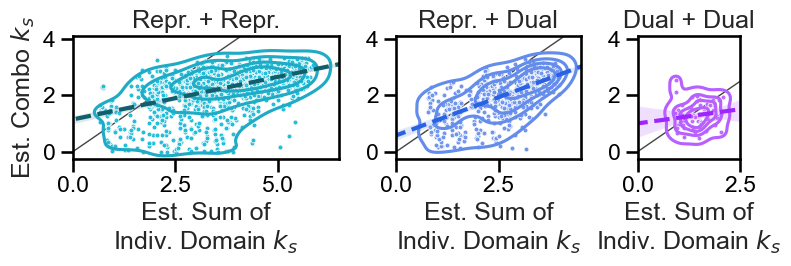

In [25]:
%%time 

xmin = 0
xmaxs = [6.5, 4.5, 2.5]

fig, ax = plt.subplots(1, 3, figsize=(8, 3), gridspec_kw={"width_ratios": xmaxs})
palette = ["#23bedb", "#7196ed", "#be6eff"]

# 777777", "#be6eff", "#7196ed", "#23bedb")


def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


titles = ["Repr. + Repr.", "Repr. + Dual", "Dual + Dual"]
for i, ct in enumerate(["R-R", "R-D", "D-D"]):
    ax[i].axline(xy1=(0, 0), slope=1, color="#444444", lw=1, zorder=-1)

    sns.scatterplot(
        data=rddf[rddf["comp_type"] == ct],
        x="sum_estimated_ks",
        y="combo_estimated_ks",
        color=palette[i],
        #         alpha=0.5,
        marker=".",
        s=50,
        ax=ax[i],
    )

    sns.kdeplot(
        data=rddf[rddf["comp_type"] == ct],
        x="sum_estimated_ks",
        y="combo_estimated_ks",
        color=lighten_color(palette[i], 1.1),
        levels=5,
        ax=ax[i],
        #         zorder=-5,
    )

    sns.regplot(
        data=rddf[rddf["comp_type"] == ct],
        x="sum_estimated_ks",
        y="combo_estimated_ks",
        scatter=False,
        truncate=False,
        color=lighten_color(palette[i], 1.5),
        line_kws={
            "linestyle": "--",
            "lw": 3,
        },
        robust=True,
        ax=ax[i],
    )

    ax[i].set_xlim(xmin, xmaxs[i])
    ax[i].set_ylim(-0.25, 4.1)
    ax[i].set_yticks([0, 2, 4])
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Est. Sum of\nIndiv. Domain $k_s$")
    if i == 0:
        ax[i].set_ylabel("Est. Combo $k_s$")
    else:
        ax[i].set_ylabel("")


r, p = st.pearsonr(rddf["sum_estimated_ks"], rddf["combo_estimated_ks"])
print("r={:.02f}, p={:.02f}".format(r, p))

plt.tight_layout()

fig.savefig("./repr_ks_scatters.pdf", bbox_inches="tight")

r=0.56, p=0.00
CPU times: user 18.1 s, sys: 260 ms, total: 18.3 s
Wall time: 16.4 s


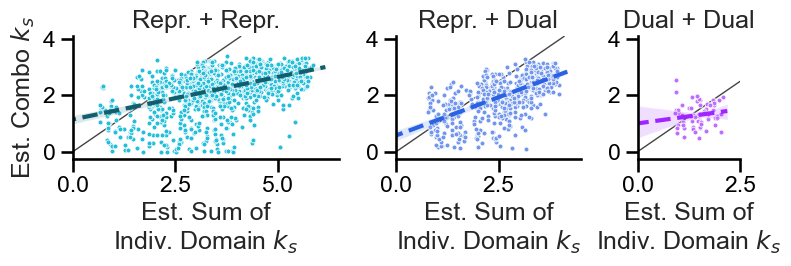

In [26]:
%%time 
# a plot sans contours

xmin = 0
xmaxs = [6.5, 4.5, 2.5]

fig, ax = plt.subplots(1, 3, figsize=(8, 3), gridspec_kw={"width_ratios": xmaxs})
palette = ["#23bedb", "#7196ed", "#be6eff"]

# 777777", "#be6eff", "#7196ed", "#23bedb")


def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


titles = ["Repr. + Repr.", "Repr. + Dual", "Dual + Dual"]
for i, ct in enumerate(["R-R", "R-D", "D-D"]):
    ax[i].axline(xy1=(0, 0), slope=1, color="#444444", lw=1, zorder=-1)

    sns.scatterplot(
        data=rddf[rddf["comp_type"] == ct],
        x="sum_estimated_ks",
        y="combo_estimated_ks",
        color=palette[i],
        #         alpha=0.5,
        marker=".",
        s=50,
        ax=ax[i],
    )

    sns.regplot(
        data=rddf[rddf["comp_type"] == ct],
        x="sum_estimated_ks",
        y="combo_estimated_ks",
        scatter=False,
        truncate=False,
        color=lighten_color(palette[i], 1.5),
        line_kws={
            "linestyle": "--",
            "lw": 3,
        },
        robust=True,
        ax=ax[i],
    )

    ax[i].set_xlim(xmin, xmaxs[i])
    ax[i].set_ylim(-0.25, 4.1)
    ax[i].set_yticks([0, 2, 4])
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Est. Sum of\nIndiv. Domain $k_s$")
    if i == 0:
        ax[i].set_ylabel("Est. Combo $k_s$")
    else:
        ax[i].set_ylabel("")


r, p = st.pearsonr(rddf["sum_estimated_ks"], rddf["combo_estimated_ks"])
print("r={:.02f}, p={:.02f}".format(r, p))

sns.despine(fig)
plt.tight_layout()

fig.savefig("./repr_ks_scatters_nocontour.pdf", bbox_inches="tight")

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [28]:
def get_fmodel(ct):
    if ct != "All":
        fmodel = ols(
            "combo_estimated_ks ~ sum_estimated_ks", data=rddf[rddf["comp_type"] == ct]
        ).fit()
    else:
        fmodel = ols("combo_estimated_ks ~ sum_estimated_ks", data=rddf).fit()
    fdf = fmodel.summary2().tables[1].reset_index()
    fdf["ctype"] = ct
    fdf["variable"] = fdf["index"]
    fdf = fdf[["variable", "Coef.", "Std.Err.", "ctype"]]
    return fdf


model_df = pd.concat([get_fmodel(ct) for ct in ["All", "R-R", "R-D", "D-D"]])
model_df = (
    model_df.melt(
        id_vars=["ctype", "variable"],
        value_vars=["Coef.", "Std.Err."],
        var_name="descr",
    )
    .pivot(index=["ctype", "variable"], columns="descr", values="value")
    .reset_index()
)
model_df["ctype"] = pd.Categorical(model_df["ctype"], ["All", "R-R", "R-D", "D-D"])
model_df

descr,ctype,variable,Coef.,Std.Err.
0,All,Intercept,0.951424,0.043537
1,All,sum_estimated_ks,0.346864,0.012519
2,D-D,Intercept,1.169436,0.247558
3,D-D,sum_estimated_ks,0.097072,0.166311
4,R-D,Intercept,0.562538,0.078101
5,R-D,sum_estimated_ks,0.537498,0.028537
6,R-R,Intercept,0.986915,0.064476
7,R-R,sum_estimated_ks,0.325468,0.016721


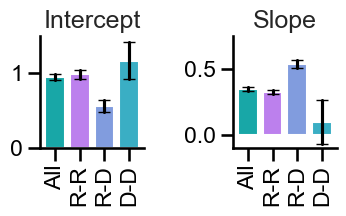

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2.5))
sns.barplot(
    data=model_df[model_df["variable"] == "Intercept"],
    x="ctype",
    y="Coef.",
    palette=["c", "#be6eff", "#7196ed", "#23bedb"],
    capstyle="projecting",
    ax=ax[0],
)
sns.barplot(
    data=model_df[model_df["variable"] == "sum_estimated_ks"],
    x="ctype",
    y="Coef.",
    palette=["c", "#be6eff", "#7196ed", "#23bedb"],
    capstyle="projecting",
    ax=ax[1],
)

for a in ax.flat:
    a.set_xlabel("")
    a.set_ylabel("")
    for t in a.get_xticklabels():
        t.set_rotation(90)

ax[0].set_title("Intercept")
ax[0].set_ylim(0, 1.5)
ax[1].set_title("Slope")
ax[1].set_ylim(-0.1, 0.75)

for i, ct in enumerate(["All", "R-R", "R-D", "D-D"]):
    ise = list(
        model_df[(model_df["ctype"] == ct) & (model_df["variable"] == "Intercept")][
            "Std.Err."
        ]
    )[0]
    icf = list(
        model_df[(model_df["ctype"] == ct) & (model_df["variable"] == "Intercept")][
            "Coef."
        ]
    )[0]
    ax[0].plot([i, i], [icf - ise, icf + ise], color="k", marker="_")

    ise = list(
        model_df[
            (model_df["ctype"] == ct) & (model_df["variable"] == "sum_estimated_ks")
        ]["Std.Err."]
    )[0]
    icf = list(
        model_df[
            (model_df["ctype"] == ct) & (model_df["variable"] == "sum_estimated_ks")
        ]["Coef."]
    )[0]
    ax[1].plot([i, i], [icf - ise, icf + ise], color="k", marker="_")


sns.despine()
plt.tight_layout()

plt.savefig("./repr_ks_scatter_fits_ols.pdf", bbox_inches="tight")

# Sigmoid of day 5 frac off

In [30]:
def estimate_d5(screen_score):
    return n_sigmoid(screen_score, *co_popt)


rddf["combo_est_d5"] = estimate_d5(rddf["avg_enrichment_d5"])
rddf["d1_est_d5"] = estimate_d5(rddf["d1_med_d5"])
rddf["d2_est_d5"] = estimate_d5(rddf["d2_med_d5"])
rddf["sum_est_d5"] = rddf["d1_est_d5"] + rddf["d2_est_d5"]
rddf["cap_est_d5"] = np.minimum(1, rddf["d1_est_d5"] + rddf["d2_est_d5"])
rddf["avg_est_d5"] = (rddf["d1_est_d5"] + rddf["d2_est_d5"])/2.0
rddf["max_est_d5"] = np.maximum(rddf["d1_est_d5"], rddf["d2_est_d5"])
rddf["min_est_d5"] = np.minimum(rddf["d1_est_d5"], rddf["d2_est_d5"])

rddf = rddf.dropna(subset=["sum_est_d5", "combo_est_d5"])
rddf = rddf.sort_values(by="comp_type", ascending=False)

rddf[["sum_est_d5", "combo_est_d5"]].describe()

,sum_est_d5,combo_est_d5
count,1718.000000,1718.000000
mean,1.297978,0.791191
std,0.406422,0.225922
min,0.229431,0.000000
25%,1.038909,0.749179
50%,1.311242,0.887160
75%,1.668517,0.931481
max,1.912393,0.983689


# Let's do this properly?

In [31]:
qdf = df
qdf['citrine OFF'] = qdf['mCitrine-A'] < citrine_threshold
mdf = (
    qdf.groupby(["day", "plasmid", "description", "replicate", "dox"])
    .mean()
    .reset_index()
)
mdf = mdf.pivot(
    index=["plasmid", "description", "replicate", "day"], columns="dox", values="citrine OFF"
).reset_index()
mdf['norm_off'] = (mdf[1000.0]-mdf[0.0])/(1.0-mdf[0.0])
mdf = mdf.groupby(['plasmid', 'description', 'day']).mean().reset_index()
mdf = mdf[['plasmid', 'description', 'day', 'norm_off']]

pdf = mdf[(mdf["plasmid"] > 73) & (~mdf["plasmid"].isin([126, 217, 222, 144]))]

pairs = [
    get_domains(p, d)
    for p, d in zip(list(pdf["plasmid"]), list(pdf["description"]))
]
pdf["domain1"] = [p[0] for p in pairs]
pdf["domain2"] = [p[1] for p in pairs]
pdf["pair"] = [p[0] + " --- " + p[1] for p in pairs]

jdf = pdf.set_index('pair').join(
    screen_data.set_index('pair'),
    how = 'left',
    rsuffix = '_screen'
).reset_index()

print(sorted(list(set(list(jdf["day"])))))

jdf.head()

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_4786/2187559237.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["domain1"] = [p[0] for p in pairs]
/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_4786/2187559237.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["domain2"] = [p[1] for p in pairs]
/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_4786/2187559237.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,pair,plasmid,description,day,norm_off,domain1,domain2,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,...,character,ptype,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5,combo_estimated_ks,d1_estimated_ks,d2_estimated_ks,sum_estimated_ks
0,DMD_control_tiles;ENSG00000198947;;131; --- DM...,74,DMD - DMD,0.0,0.000000,DMD_control_tiles;ENSG00000198947;;131;,DMD_control_tiles;ENSG00000198947;;297;,2 control Pair,-1.357524,2.056711,...,Control,Control Pair,False,False,NaN,NaN,0.175852,0.744039,NaN,NaN
1,DMD_control_tiles;ENSG00000198947;;131; --- DM...,74,DMD - DMD,1.0,0.009189,DMD_control_tiles;ENSG00000198947;;131;,DMD_control_tiles;ENSG00000198947;;297;,2 control Pair,-1.357524,2.056711,...,Control,Control Pair,False,False,NaN,NaN,0.175852,0.744039,NaN,NaN
2,DMD_control_tiles;ENSG00000198947;;131; --- DM...,74,DMD - DMD,2.0,-0.005115,DMD_control_tiles;ENSG00000198947;;131;,DMD_control_tiles;ENSG00000198947;;297;,2 control Pair,-1.357524,2.056711,...,Control,Control Pair,False,False,NaN,NaN,0.175852,0.744039,NaN,NaN
3,DMD_control_tiles;ENSG00000198947;;131; --- DM...,74,DMD - DMD,3.0,0.005982,DMD_control_tiles;ENSG00000198947;;131;,DMD_control_tiles;ENSG00000198947;;297;,2 control Pair,-1.357524,2.056711,...,Control,Control Pair,False,False,NaN,NaN,0.175852,0.744039,NaN,NaN
4,DMD_control_tiles;ENSG00000198947;;131; --- DM...,74,DMD - DMD,4.0,-0.006258,DMD_control_tiles;ENSG00000198947;;131;,DMD_control_tiles;ENSG00000198947;;297;,2 control Pair,-1.357524,2.056711,...,Control,Control Pair,False,False,NaN,NaN,0.175852,0.744039,NaN,NaN


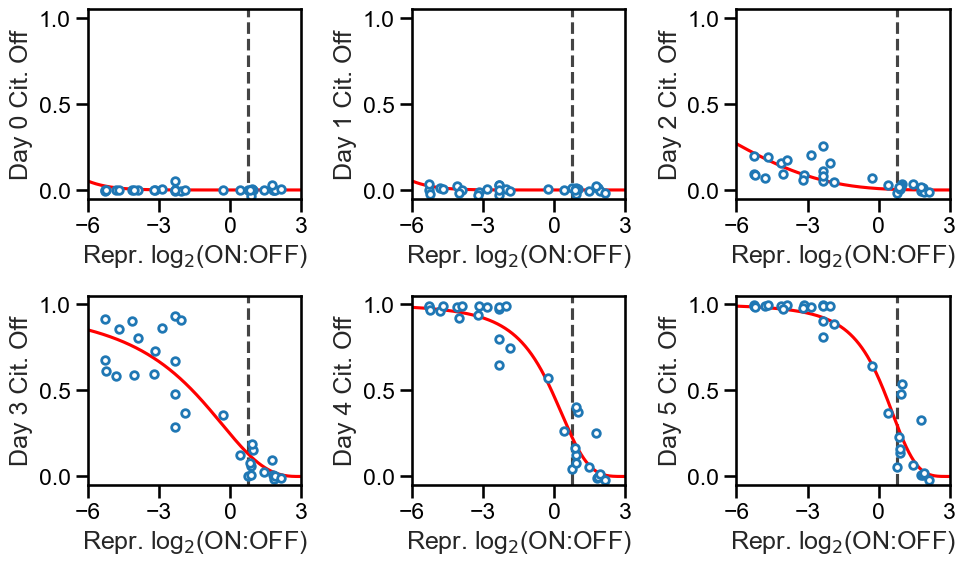

In [32]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

popt_dict = {}

for i, a in enumerate(ax.flat):
    adf = jdf[jdf["day"]==i].dropna(subset=["avg_enrichment_d5", "norm_off"])
    
    popt, _ = curve_fit(
        f=n_sigmoid,
        xdata=np.array(list(adf["avg_enrichment_d5"])),
        ydata=np.array(list(adf["norm_off"])),
        p0=[3, -2.5, 5],
        bounds=[[2.9, -9, 1], [3.001, 3, 10]],
        method="dogbox",
    )
    popt_dict[i] = popt

    a.axvline(0.771, ymin=0, ymax=1.0, color="#444444", linestyle="--", zorder=-10)

    sns.scatterplot(
        data=adf,
        x="avg_enrichment_d5",
        y="norm_off",
        marker="o",
        edgecolor="tab:blue",
        linewidth=2,
        color="white",
        s=30,
        ax=a,
    )

    a.set_xlim(-6, 3)
    a.set_xticks([-6, -3, 0, 3])
    a.set_ylim(-0.05, 1.05)
    a.set_yticks([0, 0.5, 1.0])

    a.plot(
        np.linspace(-6, 3, 1000),
        n_sigmoid(np.linspace(-6, 3, 1000), *popt),
        color="red",
        zorder=-10,
    )

    a.set_xlabel("Repr. log$_2$(ON:OFF)")
    a.set_ylabel("Day " + str(i) + " Cit. Off")

plt.tight_layout()

fig.savefig("./repr_citoff_screen_sigmoids.pdf", bbox_inches="tight")

In [33]:
popt_dict

{0: array([ 2.9, -9. , 10. ]),
 1: array([ 2.9, -9. , 10. ]),
 2: array([ 3.001     , -9.        ,  3.48865203]),
 3: array([ 2.9       , -1.58592466,  2.53999892]),
 4: array([ 3.001     , -0.11927694,  3.72935404]),
 5: array([3.001     , 0.21655973, 3.77973363])}

In [34]:
def estimate_off(s, d):
    return n_sigmoid(s, *popt_dict[d])


for i in sorted(list(popt_dict.keys())):
    rddf["combo_est_d" + str(i)] = estimate_off(rddf["avg_enrichment_d5"], i)
    rddf["d1_est_d" + str(i)] = estimate_off(rddf["d1_med_d5"], i)
    rddf["d2_est_d" + str(i)] = estimate_off(rddf["d2_med_d5"], i)
    rddf["est_of_sum_d" + str(i)] = estimate_off(
        rddf["d1_med_d5"] + rddf["d2_med_d5"], i
    )
    rddf["sum_est_d" + str(i)] = rddf["d1_est_d" + str(i)] + rddf["d2_est_d" + str(i)]
    rddf["cap_est_d" + str(i)] = np.minimum(
        1, rddf["d1_est_d" + str(i)] + rddf["d2_est_d" + str(i)]
    )
    rddf["avg_est_d" + str(i)] = (
        rddf["d1_est_d" + str(i)] + rddf["d2_est_d" + str(i)]
    ) / 2.0
    rddf["max_est_d" + str(i)] = np.maximum(
        rddf["d1_est_d" + str(i)], rddf["d2_est_d" + str(i)]
    )
    rddf["min_est_d" + str(i)] = np.minimum(
        rddf["d1_est_d" + str(i)], rddf["d2_est_d" + str(i)]
    )
rddf.head()

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,combo_est_d4,d1_est_d4,d2_est_d4,est_of_sum_d4,sum_est_d4,cap_est_d4,avg_est_d4,max_est_d4,min_est_d4,est_of_sum_d5
5033,Short_nuclear_domain;BIN1_HUMAN;SH3_9;513;63 -...,0 control Pair,-6.596375,-2.513918,NaN,0.053101,0.010229,0.148994,NaN,0.509201,...,0.756946,0.172607,0.818553,0.658753,0.991160,0.991160,0.495580,0.818553,0.172607,0.749706
4848,Short_nuclear_domain;CREM_HUMAN;bZIP_1;265;45 ...,0 control Pair,-3.759838,-1.315935,-3.822935,-1.994205,0.068745,0.286563,0.065998,0.200643,...,0.816479,0.628738,0.862694,0.904416,1.491432,1.000000,0.745716,0.862694,0.628738,0.937501
4874,Human_KRAB_variant;Q3KP31;676 --- Short_nuclea...,0 control Pair,-4.360860,2.035068,-2.957865,-1.647339,0.046410,0.803861,0.114029,0.241981,...,0.402657,0.920097,0.436069,0.915927,1.356166,1.000000,0.678083,0.920097,0.436069,0.945367
201,Silencer_tiles;ENSG00000111642;38 --- Silencer...,0 control Pair,-0.760744,-1.967558,-2.115717,-1.516408,0.371145,0.203622,0.187475,0.259015,...,0.826589,0.878831,0.745650,0.938189,1.624481,1.000000,0.812241,0.878831,0.745650,0.960343
4872,Short_nuclear_domain;MPP8_HUMAN;Chromo;44;50 -...,0 control Pair,-3.058775,-2.812088,NaN,-5.618192,0.107151,0.124642,NaN,0.019953,...,0.957980,0.904413,0.080107,0.771004,0.984519,0.984519,0.492260,0.904413,0.080107,0.840346


  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 6.25 s, sys: 286 ms, total: 6.54 s
Wall time: 4.66 s


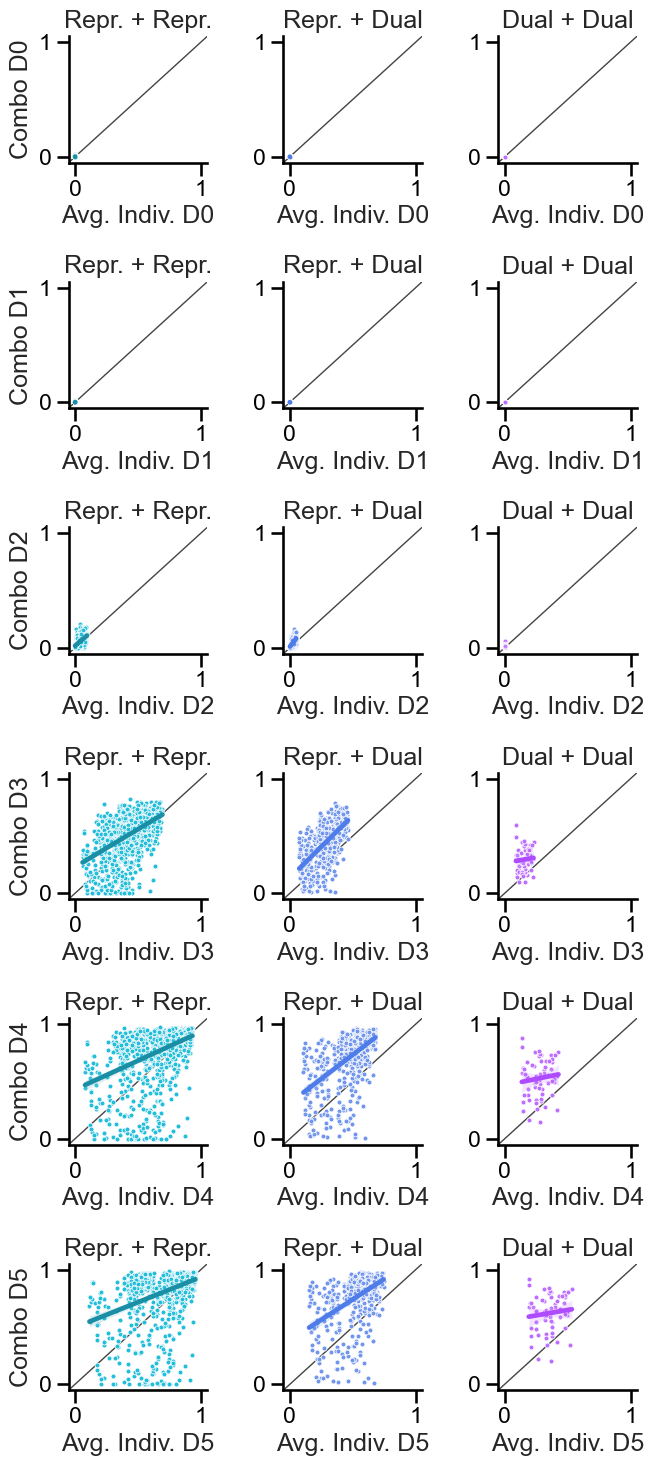

In [35]:
%%time
# a plot sans contours

xmin = 0

fig, axes = plt.subplots(6, 3, figsize=(7, 15), gridspec_kw={"width_ratios": [1, 1, 1]})
palette = ["#23bedb", "#7196ed", "#be6eff"]
titles = ["Repr. + Repr.", "Repr. + Dual", "Dual + Dual"]

for j, ax in tqdm(enumerate(axes), total=len(axes)):
    for i, ct in enumerate(["R-R", "R-D", "D-D"]):
        ax[i].axline(xy1=(0, 0), slope=1, color="#444444", lw=1, zorder=-1)

        xvar = "avg_est_d"+str(j)
        yvar = "combo_est_d"+str(j)

        sns.scatterplot(
            data=rddf[rddf["comp_type"] == ct],
            x=xvar,
            y=yvar,
            color=palette[i],
            marker=".",
            s=50,
            ax=ax[i],
        )
        
        sns.regplot(
            data=rddf[rddf["comp_type"] == ct],
            x=xvar,
            y=yvar,
            color=lighten_color(palette[i], 1.25),
            scatter=False,
            robust=False,
            ax=ax[i],
        )


        ax[i].set_title(titles[i])
        ax[i].set_xlabel("Avg. Indiv. D"+str(j))
        if i == 0:
            ax[i].set_ylabel("Combo D"+str(j))
        else:
            ax[i].set_ylabel("")
        ax[i].set_xlim(-0.05, 1.05)
        ax[i].set_ylim(-0.05, 1.05)


sns.despine(fig)
plt.tight_layout()

fig.savefig("./citoff_scatters_alldays.pdf", bbox_inches = "tight")
fig.savefig("./citoff_scatters_alldays.png", dpi=450)

CPU times: user 2.88 s, sys: 254 ms, total: 3.13 s
Wall time: 426 ms


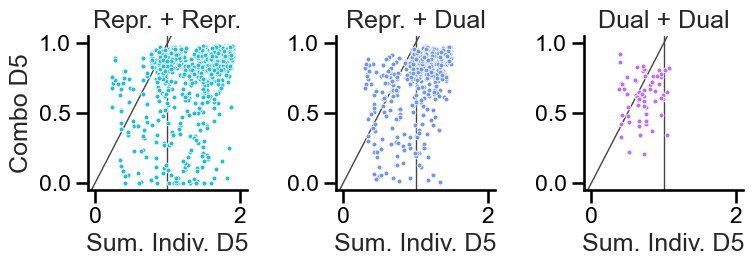

In [36]:
%%time
# a plot sans contours

xmin = 0

fig, ax = plt.subplots(1, 3, figsize=(8, 3), gridspec_kw={"width_ratios": [1, 1, 1]})
palette = ["#23bedb", "#7196ed", "#be6eff"]


titles = ["Repr. + Repr.", "Repr. + Dual", "Dual + Dual"]
for i, ct in enumerate(["R-R", "R-D", "D-D"]):
    ax[i].axline(xy1=(0, 0), slope=1, color="#444444", lw=1, zorder=-1)
    ax[i].axvline(x=1, color="#444444", lw=1, zorder=-1)

    xvar = "sum_est_d5"
    yvar = "combo_est_d5"
    
    sns.scatterplot(
        data=rddf[rddf["comp_type"] == ct],
        x=xvar,
        y=yvar,
        color=palette[i],
        marker=".",
        s=50,
#         alpha=0.5,
        ax=ax[i],
#         scatter_kws = {
#             "s" : 50,
#             "edgecolor" : "w",
#             "alpha" : 0.5,
#         },
#         line_kws = {
#             "color" : lighten_color(palette[i], 1.25)
#         }
    )
        
    ax[i].set_xlim(-0.05, 1.05)
    ax[i].set_xlim(-0.1, 2.1)
    ax[i].set_ylim(-0.05, 1.05)
    

    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Sum. Indiv. D5")
    if i == 0:
        ax[i].set_ylabel("Combo D5")
    else:
        ax[i].set_ylabel("")


sns.despine(fig)
plt.tight_layout()

fig.savefig("./citoff_scatter_avg_combo_d5.pdf", bbox_inches="tight")

/Users/axm/anaconda3/envs/flow/lib/python3.8/site-packages/seaborn/axisgrid.py:1668: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


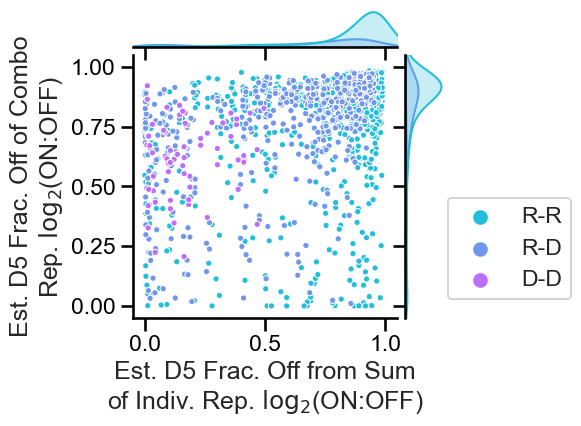

In [37]:
g = sns.jointplot(
    data=rddf,
    x="est_of_sum_d5",
    y=yvar,
    hue="comp_type",
    palette=palette,
    joint_kws = {
        "marker" : "."
    },
    height=4,
    ratio = 6,
)

g.ax_joint.set_xlabel("Est. D5 Frac. Off from Sum\nof Indiv. Rep. $\log_2$(ON:OFF)")
g.ax_joint.set_ylabel("Est. D5 Frac. Off of Combo\nRep. $\log_2$(ON:OFF)")

for i, ct in enumerate(["R-R", "R-D", "D-D"]):
    xvar = "est_of_sum_d5"
    yvar = "combo_est_d5"
    

g.ax_joint.set_xlim(-0.05, 1.05)
g.ax_joint.set_ylim(-0.05, 1.05)
l = g.ax_joint.legend(bbox_to_anchor=(1.7, 0.5))

g.savefig("./est_d5_combo_vs_est_d5_estofsum_jointplot.pdf", bbox_inches="tight")

In [38]:
print(list(rddf))
singles_df = (
    rddf.groupby("domain1")[["d1_med_d5", "d1_est_d5", "d1_baseline_type"]]
    .first()
    .reset_index()
)
singles_df

['pair', 'type', 'enrichment_ratio_r1_d2', 'enrichment_ratio_r1_d5', 'enrichment_ratio_r2_d2', 'enrichment_ratio_r2_d5', 'enrichment_fraction_r1_d2', 'enrichment_fraction_r1_d5', 'enrichment_fraction_r2_d2', 'enrichment_fraction_r2_d5', 'bound_r1_d2', 'bound_r1_d5', 'bound_r2_d2', 'bound_r2_d5', 'unbound_r1_d2', 'unbound_r1_d5', 'unbound_r2_d2', 'unbound_r2_d5', 'norm_bound_r1_d2', 'norm_bound_r1_d5', 'norm_bound_r2_d2', 'norm_bound_r2_d5', 'norm_unbound_r1_d2', 'norm_unbound_r1_d5', 'norm_unbound_r2_d2', 'norm_unbound_r2_d5', 'avg_enrichment_d2', 'avg_enrichment_d5', 'domain1', 'domain2', 'd1_Gene', 'd1_Pathway', 'd1_Description', 'd2_Gene', 'd2_Pathway', 'd2_Description', 'd1_avg_d2', 'd1_med_d2', 'd1_sd_d2', 'd1_min_d2', 'd1_max_d2', 'd1_delta_min_d2', 'd1_delta_max_d2', 'd1_avg_d5', 'd1_med_d5', 'd1_sd_d5', 'd1_min_d5', 'd1_max_d5', 'd1_delta_min_d5', 'd1_delta_max_d5', 'd1_frac_d2', 'd1_frac_d5', 'd1_description', 'd1_baseline_type', 'd1_prior_type', 'd2_avg_d2', 'd2_med_d2', 'd2_

,domain1,d1_med_d5,d1_est_d5,d1_baseline_type
0,Human_KRAB_variant;M0QYP0;367,-2.908214,0.945014,Repressor
1,Human_KRAB_variant;P21506;146,-3.120449,0.951547,Repressor
2,Human_KRAB_variant;Q3KP31;676,-3.007482,0.948196,Repressor
3,Short_nuclear_domain;ASCL1_HUMAN;HLH;105;52,-0.619460,0.729559,Repressor
4,Short_nuclear_domain;ATF1_HUMAN;bZIP_1;191;59,-0.608552,0.727303,Repressor
5,Short_nuclear_domain;BIN1_HUMAN;SH3_9;513;63,0.951345,0.239028,Repressor
6,Short_nuclear_domain;CACO1_HUMAN;Zn-C2H2_12;61...,1.340196,0.124209,Repressor
7,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,-2.642873,0.935262,Repressor
8,Short_nuclear_domain;CDYL2_HUMAN;Chromo;1;50,-3.294145,0.956196,Repressor
9,Short_nuclear_domain;CHD3_HUMAN;DUF1087;1286;60,0.983405,0.228358,Repressor


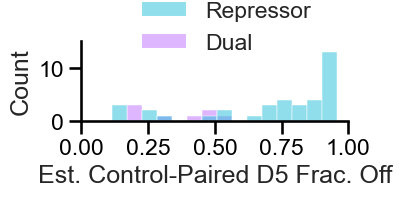

In [39]:
# fig, ax = plt.subplots(figsize=(5, 3))

g = sns.displot(
    data=singles_df,
    x="d1_est_d5",
    hue="d1_baseline_type",
    palette=[palette[0], palette[2]],
    kind="hist",
    height=2,
    aspect=1,
    bins=15,
    #     ax=ax
)

g.ax.set_xlim(0, 1)
g.ax.set_xlabel("Est. Control-Paired D5 Frac. Off")
g.ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
g.ax.set_ylim(0, 15)
g.legend.set_title("")
g.legend.set_bbox_to_anchor((0.8, 0.85))
# (fontsize=12, bbox_to_anchor=(1.4, 1.0))

plt.tight_layout()

g.savefig("./repr_dual_estd5_hist.pdf", bbox_inches="tight")

CPU times: user 770 ms, sys: 48.9 ms, total: 819 ms
Wall time: 415 ms


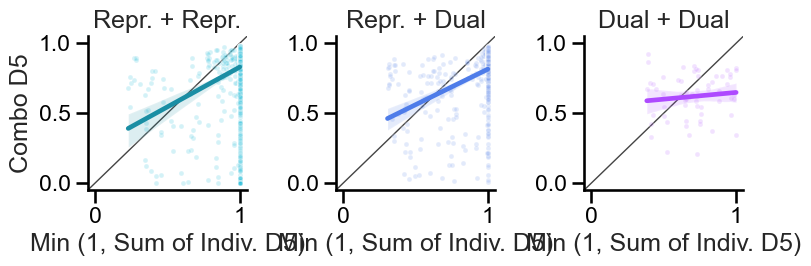

In [40]:
%%time
# a plot sans contours

xmin = 0

fig, ax = plt.subplots(1, 3, figsize=(8, 3), gridspec_kw={"width_ratios": [1, 1, 1]})
palette = ["#23bedb", "#7196ed", "#be6eff"]


titles = ["Repr. + Repr.", "Repr. + Dual", "Dual + Dual"]
for i, ct in enumerate(["R-R", "R-D", "D-D"]):
    ax[i].axline(xy1=(0, 0), slope=1, color="#444444", lw=1, zorder=-1)

    xvar = "cap_est_d5"
    yvar = "combo_est_d5"

    sns.regplot(
        data=rddf[rddf["comp_type"] == ct],
        x=xvar,
        y=yvar,
        color=palette[i],
        marker=".",
        ax=ax[i],
        scatter_kws = {
            "s" : 50,
            "edgecolor" : "w",
            "alpha" : 0.2,
        },
        line_kws = {
            "color" : lighten_color(palette[i], 1.25)
        },
    )
    
    ax[i].set_xlim(-0.05, 1.05)
    ax[i].set_ylim(-0.05, 1.05)

    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Min (1, Sum of Indiv. D5)")
    if i == 0:
        ax[i].set_ylabel("Combo D5")
    else:
        ax[i].set_ylabel("")


sns.despine(fig)
plt.tight_layout()

# fig.savefig("./citoff_scatter_max_combo_d5.pdf", bbox_inches="tight")

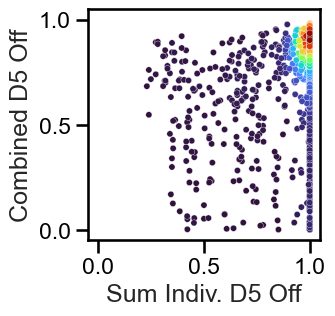

In [41]:
fig, ax = plt.subplots(figsize=(3, 3))

xvar = "cap_est_d5"

kfit = st.gaussian_kde(np.array(rddf[[xvar, "combo_est_d5"]]).T)
rddf["local_density"] = kfit.pdf(np.array(rddf[[xvar, "combo_est_d5"]]).T)


sns.scatterplot(
    data=rddf,
    x=xvar,
    y="combo_est_d5",
    hue="local_density",
    palette="turbo",
    linewidth=0.25,
    marker=".",
    legend=False,
    ax=ax,
)

ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-0.05, 1.05)

ax.set_xticks([0, 0.5, 1.0])
ax.set_yticks([0, 0.5, 1.0])

ax.set_xlabel("Sum Indiv. D5 Off")
ax.set_ylabel("Combined D5 Off")

fig.savefig("./citoff_scatter_sum_combo_d5.pdf", bbox_inches="tight")

In [169]:
xvar = "combo_est_d5"

all_domains = sorted(list(set(rddf["d1_Gene"])))

correlation_dfs = []

for domain in tqdm(all_domains, total=len(all_domains)):
    fig, ax = plt.subplots(figsize=(3, 3))
    dom_df = rddf[(rddf["d1_Gene"] == domain) | (rddf["d2_Gene"] == domain)].copy()
    dom_df["dom_score"] = list(dom_df[dom_df["d1_Gene"] == domain]["d1_est_d5"])[0]
    dom_score = list(dom_df["dom_score"])[0]
    dom_type = list(rddf[(rddf["d1_Gene"] == domain)]["d1_baseline_type"])[0]
    dom_df["other_score"] = [
        list(dom_df["d1_est_d5"])[i] if d != domain else list(dom_df["d2_est_d5"])[i]
        for i, d in enumerate(list(dom_df["d1_Gene"]))
    ]
    dom_df = dom_df.dropna(subset=["dom_score", "other_score"])
    r, p = st.pearsonr(dom_df["combo_est_d5"], dom_df["other_score"])
    sig = "Significant" if p < (0.05 / len(all_domains)) else "Not Significant"

    try:
        kfit = st.gaussian_kde(np.array(dom_df[[xvar, "other_score"]]).T)
        dom_df["local_density"] = kfit.pdf(np.array(dom_df[[xvar, "other_score"]]).T)

        sns.scatterplot(
            data=dom_df,
            x="other_score",
            y="combo_est_d5",
            hue="local_density",
            palette="turbo",
            linewidth=0.25,
            marker=".",
            legend=False,
            ax=ax,
        )

    except:
        sns.scatterplot(
            data=dom_df,
            x="other_score",
            y="combo_est_d5",
            linewidth=0.25,
            marker=".",
            legend=False,
            ax=ax,
        )

    sns.regplot(
        data=dom_df,
        x="other_score",
        y="combo_est_d5",
        color="k",
        scatter=False,
        line_kws={"zorder": -5, "lw": 2},
        ax=ax,
    )

    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-0.05, 1.05)

    ax.set_xticks([0, 0.5, 1.0])
    ax.set_yticks([0, 0.5, 1.0])

    ax.set_xlabel("Other D5 Off")
    ax.set_ylabel("Combined D5 Off")

    ax.set_title(
        domain
        + "\n"
        + str(dom_type)
        + "\nEst. D5 Frac. Off: {:.02f}\nr={:.02f}, p={:.02f}".format(dom_score, r, p)
    )

    fig.savefig("./domain_plots/" + str(domain) + "_scatter.pdf", bbox_inches="tight")
    plt.close(fig)

    corr_df = pd.DataFrame.from_dict(
        {"domain": [domain], "corr": [r], "corr_p": [p], "sig": [sig]}
    )

    correlation_dfs.append(corr_df)
correlation_df = pd.concat(correlation_dfs).reset_index()
correlation_df.head()

  0%|          | 0/45 [00:00<?, ?it/s]

,index,domain,corr,corr_p,sig
0,0,ASCL1,0.138805,2.286194e-01,Not Significant
1,0,ATF1,0.470605,1.448967e-03,Not Significant
2,0,BAZ2A,0.519076,2.202401e-07,Significant
3,0,BIN1,0.758813,1.084852e-17,Significant
4,0,CACO1,0.478292,3.663341e-06,Significant


In [179]:
def get_domain_df(domain):
    dom_df = rddf[(rddf["d1_Gene"] == domain) | (rddf["d2_Gene"] == domain)].copy()
    dom_df["domain"] = domain
    dom_df["sum_lt_1"] = dom_df["sum_est_d5"] < 1.0
    dom_df["sum_lt_combo"] = dom_df["sum_est_d5"] < dom_df["combo_est_d5"]
    dom_df["cap_gt_combo"] = dom_df["cap_est_d5"] > dom_df["combo_est_d5"]
    dom_df["cap_combo_delta"] = dom_df["cap_est_d5"] - dom_df["combo_est_d5"]
    dom_df["combo_lt_75p"] = dom_df["combo_est_d5"] < 0.75
    dom_df = (
        dom_df.groupby("domain")
        .agg(
            {
                "sum_lt_1": "mean",
                "sum_lt_combo": "mean",
                "cap_gt_combo": "mean",
                "cap_combo_delta": "mean",
                "combo_lt_75p": "mean",
                "combo_est_d5": ["median", "mean", "std"],
            }
        )
        .reset_index()
    )
    dom_df["domain"] = domain
    dom_df["dom_med_d5"] = list(rddf[rddf["d1_Gene"] == domain]["d1_med_d5"])[0]
    dom_df["dom_est_d5"] = list(rddf[rddf["d1_Gene"] == domain]["d1_est_d5"])[0]
    dom_df["dom_type"] = list(rddf[rddf["d1_Gene"] == domain]["d1_baseline_type"])[0]
    return pd.DataFrame(dom_df)


ltdf = pd.concat([get_domain_df(d) for d in all_domains]).reset_index()
baseline_df = pd.read_csv("../../fig_1/03_computing_baselines/baseline_scores.csv")
oligos = pd.read_csv("../../fig_1/01_raw_counts/csvs/base_oligo_library.csv")

ltdf = (
    ltdf
    #   .set_index("domain")
    .transpose().reset_index()
)
ltdf["level"] = [
    list(ltdf["level_0"])[i] + "_" + a
    if a in ["std", "median"]
    else list(ltdf["level_0"])[i]
    for i, a in enumerate(list(ltdf["level_1"]))
]
ltdf = ltdf.transpose()
new_headers = ltdf.iloc[47]
ltdf = ltdf.set_index(1).reset_index()
ltdf = ltdf.iloc[2:]
ltdf.columns = new_headers
ltdf = ltdf.set_index("index")
ltdf = (
    ltdf.join(
        baseline_df.set_index("domain")
        .join(oligos.set_index("label"), how="left")
        .reset_index()
        .set_index("Gene"),
        how="left",
        rsuffix="_baseline",
    )
    .reset_index()
    .set_index("index")
    .join(correlation_df.set_index("domain"), how="left", rsuffix="_corrdf")
    .drop(["index", "domain"], axis=1)
    .reset_index()
)
ltdf = ltdf.drop(ltdf.tail(1).index)
ltdf.to_csv("./domains_scoresummarized.csv", index=False)

ltdf.head(n=10)

,index,sum_lt_1,sum_lt_combo,cap_gt_combo,cap_combo_delta,combo_lt_75p,combo_est_d5_median,combo_est_d5,combo_est_d5_std,dom_med_d5,...,baseline_type,prior_type,gene,Unnamed: 0,Pathway,Description,Extended Domain DNA sequence,corr,corr_p,sig
0,ASCL1,0.207792,0.038961,0.961039,0.244372,0.38961,0.795854,0.737909,0.211469,-0.61946,...,Repressor,Repressor,NaN,8.0,Transcription factor -- HLH,NucDom Repr,AGCGGCTTCGGCTACAGCCTGCCCCAGCAGCAGCCCGCCGCCGTGG...,0.138805,2.286194e-01,Not Significant
1,ATF1,0.302326,0.046512,0.953488,0.152401,0.302326,0.855778,0.818226,0.159605,-0.608552,...,Repressor,Repressor,NaN,12.0,Transcription factor -- bZIP,NucDom Repr,CAGACCGTGGTGATGACCAGCCCCGTGACCCTGACCAGCCAGACCA...,0.470605,1.448967e-03,Not Significant
2,BAZ2A,0.022727,0.0,1.0,0.138396,0.102273,0.901735,0.861566,0.111771,-1.759775,...,Repressor,Repressor,NaN,82.0,"Bromodomain; K4 deacetylation, pRNA binding",SilTile Repr,GGTCAGGATTCTGAGCAGCCTCAGGCTCAGTTGCAGCCTGAGGCTC...,0.519076,2.202401e-07,Significant
3,BIN1,0.477273,0.227273,0.772727,0.066131,0.318182,0.866527,0.770389,0.214932,0.951345,...,Repressor,Repressor,NaN,19.0,Regulation of Myc activity,NucDom Repr,AGACTGGACCTGCCCCCCGGCTTCATGTTCAAGGTGCAGGCCCAGC...,0.758813,1.084852e-17,Significant
4,CACO1,0.647059,0.317647,0.682353,0.046824,0.364706,0.838465,0.71921,0.260195,1.340196,...,Repressor,Activator,NaN,35.0,Nuclear receptor coactivator; binds PAS domain,NucDom Act,AGCGGCGGCGAGGAGGCCAACCTGCTGCTGCCCGAGCTGGGCAGCG...,0.478292,3.663341e-06,Significant
5,CBX1,0.0,0.0,1.0,0.094052,0.026316,0.925212,0.905948,0.079957,-2.642873,...,Repressor,Repressor,NaN,0.0,HP1,NucDom Repr,GAGGAGAGCGAGAAGCCCAGAGGCTTCGCCAGAGGCCTGGAGCCCG...,-0.037901,7.451419e-01,Not Significant
6,CBX7,0.0,0.0,1.0,0.130562,0.083333,0.903589,0.869438,0.129472,-2.447402,...,Repressor,Repressor,NaN,92.0,PRC1,SilTile Repr,TTGTTTTTGCAGGAGCCTCCTGCTCCTGATGTTTTGCAGGCTGCTG...,0.223701,4.080209e-02,Not Significant
7,CDYL2,0.0,0.0,1.0,0.065774,0.0,0.944973,0.934226,0.040934,-3.294145,...,Repressor,Repressor,NaN,2.0,Chromodomain,NucDom Repr,GCCAGCGGCGACCTGTACGAGGTGGAGAGAATCGTGGACAAGAGAA...,-0.058191,6.701056e-01,Not Significant
8,CHD3,0.541667,0.222222,0.777778,0.098864,0.430556,0.840035,0.704921,0.26693,0.983405,...,Repressor,Repressor,NaN,20.0,Chromodomain; NuRD complex,NucDom Repr,AAGGTGGCCCAGTACGTGGTGAGAGAGGAGGACAAGATCGAGGAGA...,0.702316,6.211198e-12,Significant
9,CHD4,0.0,0.0,1.0,0.101041,0.037037,0.917162,0.898959,0.088058,-2.307035,...,Repressor,Repressor,NaN,87.0,Chromodomain; SNF2/RAD54 family; NuRD complex ...,SilTile Repr,GAGATTATTTTGTGTGATACTTGTCCTCGTGCTTATCATATGGTTT...,0.190668,8.819038e-02,Not Significant


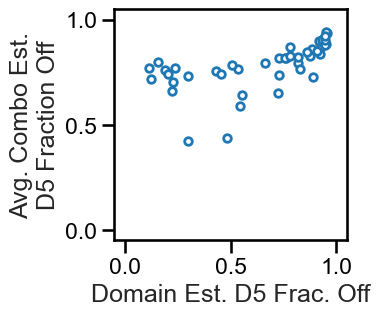

In [180]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(
    data=ltdf,
    x="dom_est_d5",
    y="combo_est_d5",
    marker="o",
    edgecolor="tab:blue",
    linewidth=2,
    color="white",
    s=30,
    ax=ax,
)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])

ax.set_xlabel("Domain Est. D5 Frac. Off")
ax.set_ylabel("Avg. Combo Est.\nD5 Fraction Off")

plt.savefig("./domd5_avgcombod5.pdf", bbox_inches="tight")

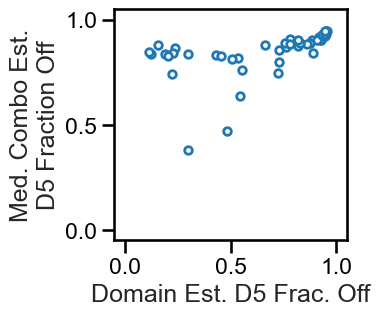

In [185]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(
    data=ltdf,
    x="dom_est_d5",
    y="combo_est_d5_median",
    marker="o",
    edgecolor="tab:blue",
    linewidth=2,
    color="white",
    s=30,
    ax=ax,
)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])

ax.set_xlabel("Domain Est. D5 Frac. Off")
ax.set_ylabel("Med. Combo Est.\nD5 Fraction Off")

plt.savefig("./domd5_medcombod5.pdf", bbox_inches="tight")

In [186]:
ltdf[ltdf["combo_est_d5_median"] <= 0.7]

,index,sum_lt_1,sum_lt_combo,cap_gt_combo,cap_combo_delta,combo_lt_75p,combo_est_d5_median,combo_est_d5,combo_est_d5_std,dom_med_d5,...,baseline_type,prior_type,gene,Unnamed: 0,Pathway,Description,Extended Domain DNA sequence,corr,corr_p,sig
13,GSX1,0.424242,0.045455,0.954545,0.430159,0.757576,0.377953,0.422656,0.32687,0.784676,...,Repressor,Repressor,NaN,15.0,Transcription factor,NucDom Repr,GTGGACAGCAGCAGCAACCAGCTGCCCAGCAGCAAGAGAATGAGAA...,0.419302,0.000458,Significant
18,HXA13,0.318182,0.045455,0.954545,0.480756,0.659091,0.469655,0.43821,0.359602,0.266925,...,Repressor,Repressor,NaN,17.0,HOXA13; homeodomain,NucDom Repr,GTGGTGAGCCACCCCAGCGACGCCAGCAGCTACAGAAGAGGCAGAA...,0.142616,0.355744,Not Significant
23,KMT2B,0.319444,0.069444,0.930556,0.34401,0.638889,0.634713,0.589376,0.273805,0.08861,...,Repressor,Repressor,NaN,16.0,MLL2; deposits H3K4me; has SET domain,NucDom Repr,GGCGGCACCCTGGCCCACACCCCCAGAAGAAGCCTGCCCAGCCACC...,0.445446,0.000088,Significant


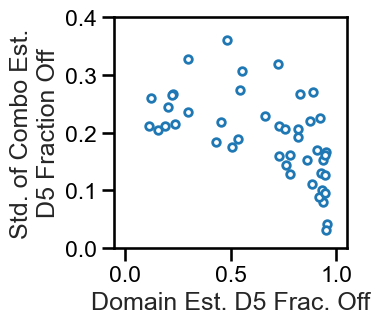

In [172]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(
    data=ltdf,
    x="dom_est_d5",
    y="combo_est_d5_std",
    marker="o",
    edgecolor="tab:blue",
    linewidth=2,
    color="white",
    s=30,
    ax=ax,
)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(0, 0.4)

ax.set_xlabel("Domain Est. D5 Frac. Off")
ax.set_ylabel("Std. of Combo Est.\nD5 Fraction Off")

plt.savefig("./std_citoff_med_score.pdf", bbox_inches="tight")

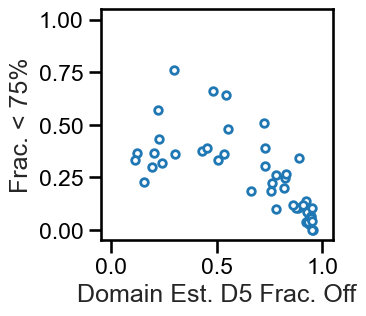

In [173]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(
    data=ltdf,
    x="dom_est_d5",
    y="combo_lt_75p",
    marker="o",
    edgecolor="tab:blue",
    linewidth=2,
    color="white",
    s=30,
    ax=ax,
)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

ax.set_xlabel("Domain Est. D5 Frac. Off")
ax.set_ylabel("Frac. < 75%")

plt.savefig("./75p_d5frac.pdf", bbox_inches="tight")

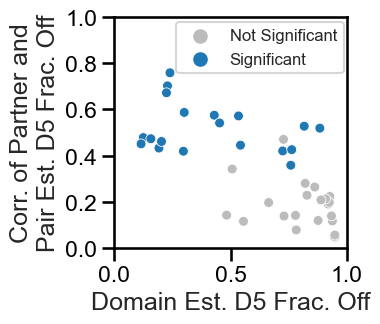

In [174]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(
    data=ltdf,
    x="dom_est_d5",
    y="corr",
    hue="sig",
    palette=["#bcbcbc", "tab:blue"],
    s=50,
    ax=ax,
)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1.0)

ax.set_xlabel("Domain Est. D5 Frac. Off")
ax.set_ylabel("Corr. of Partner and\nPair Est. D5 Frac. Off")
l = ax.legend(title="", bbox_to_anchor=(0.23, 0.72), fontsize=12)
fig.savefig("./corr_d5frac_sig.pdf", bbox_inches="tight")

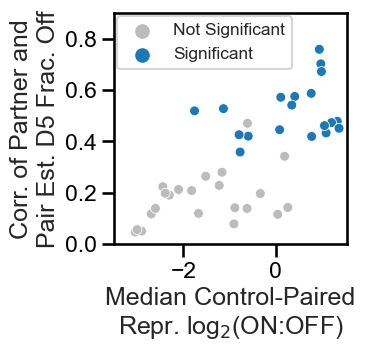

In [175]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(
    data=ltdf,
    x="dom_med_d5",
    y="corr",
    hue="sig",
    palette = ["#bcbcbc", "tab:blue"],
    s=50,
    ax=ax,
)

ax.set_xlim(-3.5, 1.55)
ax.set_ylim(0, 0.9)

ax.set_xlabel("Median Control-Paired\nRepr. log$_2$(ON:OFF)")
ax.set_ylabel("Corr. of Partner and\nPair Est. D5 Frac. Off")
l = ax.legend(title="", bbox_to_anchor=(0.8, 0.72), fontsize=12.5)
plt.savefig("./std_corr_off_med_score.pdf", bbox_inches="tight")

In [50]:
import os
import altair as alt
alt.data_transformers.enable('json', prefix='./tmp/')
alt.themes.enable('vox')

ThemeRegistry.enable('vox')

In [190]:
ltdf.head()

,index,sum_lt_1,sum_lt_combo,cap_gt_combo,cap_combo_delta,combo_lt_75p,combo_est_d5_median,combo_est_d5,combo_est_d5_std,dom_med_d5,...,baseline_type,prior_type,gene,Unnamed: 0,Pathway,Description,Extended Domain DNA sequence,corr,corr_p,sig
0,ASCL1,0.207792,0.038961,0.961039,0.244372,0.38961,0.795854,0.737909,0.211469,-0.61946,...,Repressor,Repressor,NaN,8.0,Transcription factor -- HLH,NucDom Repr,AGCGGCTTCGGCTACAGCCTGCCCCAGCAGCAGCCCGCCGCCGTGG...,0.138805,2.286194e-01,Not Significant
1,ATF1,0.302326,0.046512,0.953488,0.152401,0.302326,0.855778,0.818226,0.159605,-0.608552,...,Repressor,Repressor,NaN,12.0,Transcription factor -- bZIP,NucDom Repr,CAGACCGTGGTGATGACCAGCCCCGTGACCCTGACCAGCCAGACCA...,0.470605,1.448967e-03,Not Significant
2,BAZ2A,0.022727,0.0,1.0,0.138396,0.102273,0.901735,0.861566,0.111771,-1.759775,...,Repressor,Repressor,NaN,82.0,"Bromodomain; K4 deacetylation, pRNA binding",SilTile Repr,GGTCAGGATTCTGAGCAGCCTCAGGCTCAGTTGCAGCCTGAGGCTC...,0.519076,2.202401e-07,Significant
3,BIN1,0.477273,0.227273,0.772727,0.066131,0.318182,0.866527,0.770389,0.214932,0.951345,...,Repressor,Repressor,NaN,19.0,Regulation of Myc activity,NucDom Repr,AGACTGGACCTGCCCCCCGGCTTCATGTTCAAGGTGCAGGCCCAGC...,0.758813,1.084852e-17,Significant
4,CACO1,0.647059,0.317647,0.682353,0.046824,0.364706,0.838465,0.71921,0.260195,1.340196,...,Repressor,Activator,NaN,35.0,Nuclear receptor coactivator; binds PAS domain,NucDom Act,AGCGGCGGCGAGGAGGCCAACCTGCTGCTGCCCGAGCTGGGCAGCG...,0.478292,3.663341e-06,Significant


In [197]:
dynamic_plot = (
    alt.Chart(ltdf)
    .mark_point()
    .encode(
        x="dom_est_d5",
        y="combo_est_d5",
        color=alt.Color("sig", scale=alt.Scale(scheme="dark2")),
        tooltip=["index", "baseline_type", "dom_est_d5", "combo_est_d5"],
    )
    .properties(height=200, width=200)
)
dynamic_plot

alt.Chart(...)

# Generating Model Thingys

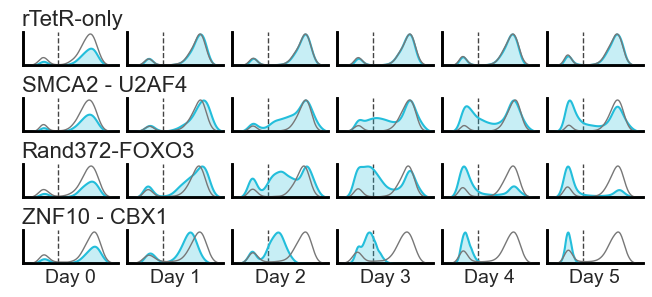

In [52]:
# make plot for znf10-cbx1

zdf = df[(df["description"] == "ZNF10 - CBX1")]
zdf.head()

plasmids = ["rTetR-only", "SMCA2 - U2AF4", "Rand372-FOXO3", "ZNF10 - CBX1"]

fig, ax = plt.subplots(
    len(plasmids),
    6,
    figsize=(8, 0.75 * len(plasmids)),
    gridspec_kw={"wspace": 0.1, "hspace": 1.0},
)

for j, arow in enumerate(ax):
    ymax = 2.0

    zdf = df[df["description"] == plasmids[j]]

    arow[0].text(2.9e5, 1.2 * ymax, plasmids[j], fontsize=16)

    for i, a in enumerate(arow):
        zzz = zdf[zdf["day"] == i]
        a2 = a.twinx()
        g = sns.kdeplot(
            data=zzz[zzz["dox"] == 0],
            x="mCitrine-A",
            color="#777777",
            linewidth=1.0,
            fill=False,
            log_scale=True,
            zorder=-10,
            ax=a2,
        )
        g = sns.kdeplot(
            data=zzz[zzz["dox"] == 1000],
            x="mCitrine-A",
            color="#23bedb",
            fill=True,
            log_scale=True,
            zorder=5,
            ax=a,
        )
        a.set_xlim(3.16e5, 3e9)
        if i == 0:
            a.set_ylim(0, ymax)
        a.set_ylabel("")
        a.set_yticks([])
        
        a.axvline(1e7, color="#444444", ls="--", lw=1, zorder=-5)

        if j == len(ax) - 1:
            a.set_xlabel("Day " + str(i), fontsize=14)
        else:
            a.set_xlabel("")

        a.set_xticks([])

        a2.tick_params(
            axis="y",
            labelcolor="w",
            left=False,
            right=False,
            labelleft=False,
            labelright=False,
        )
        a2.set_ylabel("")


sns.despine(fig)

fig.savefig("./repressor_histograms.pdf", bbox_inches="tight")

  0%|          | 0/8 [00:00<?, ?it/s]

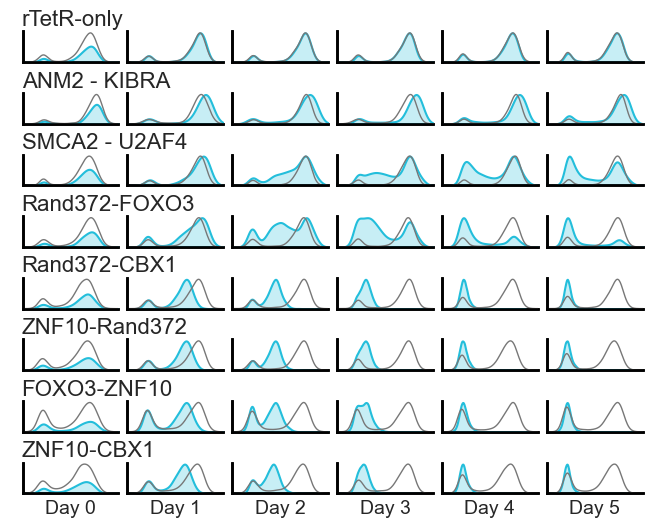

In [53]:
# make plot for znf10-cbx1

zdf = df[(df["description"] == "ZNF10 - CBX1")]
zdf.head()

plasmids = [
    "rTetR-only",
    "ANM2 - KIBRA",
    "SMCA2 - U2AF4",
    "Rand372-FOXO3",
    "Rand372-CBX1",
    "ZNF10-Rand372",
    "FOXO3-ZNF10",
    "ZNF10-CBX1",
]

fig, ax = plt.subplots(
    len(plasmids),
    6,
    figsize=(8, 0.75 * len(plasmids)),
    gridspec_kw={"wspace": 0.1, "hspace": 1.0},
)

for j, arow in tqdm(enumerate(ax), total=len(ax)):
    ymax = 2.0

    zdf = df[df["description"] == plasmids[j]]

    arow[0].text(2.9e5, 1.2 * ymax, plasmids[j], fontsize=16)

    for i, a in enumerate(arow):
        zzz = zdf[zdf["day"] == i]
        a2 = a.twinx()
        g = sns.kdeplot(
            data=zzz[zzz["dox"] == 0],
            x="mCitrine-A",
            color="#777777",
            linewidth=1.0,
            fill=False,
            log_scale=True,
            zorder=-10,
            ax=a2,
        )
        g = sns.kdeplot(
            data=zzz[zzz["dox"] == 1000],
            x="mCitrine-A",
            color="#23bedb",
            fill=True,
            log_scale=True,
            zorder=5,
            ax=a,
        )
        a.set_xlim(3.16e5, 3e9)
        if i == 0:
            a.set_ylim(0, ymax)
        a.set_ylabel("")
        a.set_yticks([])

        if j == len(ax) - 1:
            a.set_xlabel("Day " + str(i), fontsize=14)
        else:
            a.set_xlabel("")

        a.set_xticks([])

        a2.tick_params(
            axis="y",
            labelcolor="w",
            left=False,
            right=False,
            labelleft=False,
            labelright=False,
        )
        a2.set_ylabel("")


sns.despine(fig)

# fig.savefig("./repressor_histograms.pdf", bbox_inches="tight")